In [1]:
## Python package imports 
import numpy as np
import matplotlib
import os
import scipy.integrate as sint
import matplotlib.pyplot as plt

## respic imports
from rsrespic.fields import fields
from rsrespic.particles import particles
from rsrespic.solvers import solvers
from rsrespic.utilities import constants, diagnostics, utilities

## constants 
q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
c_mks = c / 100.
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']
pi = np.pi


In [2]:
## Particle definitions and simulation setup
sigma_x = 0.2
sigma_xp = sigma_x / 100.
charge_per_cm_mks = 1.0e-11  # Charge per cm
charge_per_meter = charge_per_cm_mks * 100
Q = constants.charge_mks_to_cgs(charge_per_cm_mks)

n_particles = 10000
ds = 1.0
s = 0
E = 2.0e6

## This is where we initialize a gaussian distribuiton
distribution = particles.distribution(N = n_particles)
distribution.construct_uniform_guassian_2D(sigma_x = sigma_x, sigma_y = sigma_x,
                                          sigma_xp = sigma_xp, sigma_yp = sigma_xp)


In [3]:
## Particle distributions
# The first beam is the one that uses the drift map
my_gaussian_beam = particles.particles_2D_delta(distribution, bunch_charge = Q, 
            species_mass = m_p, K_e = E)

## Define the fields 
L_0 = 10. * sigma_x ## Half the domain size
L_min = L_0 / 10. ## minimum wavelength to resolve

my_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
    L_x_min = L_min, L_y_min = L_min)

## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()
my_fields.register_solver(field_solver)

## Diagnostics 
respic_diag = diagnostics.bunch_statistics()
matrix_diag = diagnostics.bunch_statistics(divergence_coordinates = True)


In [4]:
## Load the maps
maps = solvers.symplectic_maps()

## Define stepper
def step(fields, particles, ds = ds):
    maps.drift(particles, ds = ds / 2.)
    maps.space_charge_kick_2D(fields, particles, ds = ds)
    maps.drift(particles, ds = ds / 2.)


In [5]:
## Here we run the simulation, 100 steps using the stepper functions defined in the previous block

respic_diag.update(s, my_gaussian_beam)

k = 0

while k < 100:

    step(my_fields, my_gaussian_beam)
    
    s = s + ds
    
    respic_diag.update(s, my_gaussian_beam)
        
    k = k + 1

In [6]:
## Analytic model with the same current as rsrespic
current = my_gaussian_beam.beta * c_mks * charge_per_meter

analytic_solution = utilities.calculate_expansion(current, my_gaussian_beam.beta, my_gaussian_beam.gamma, sigma_x / 100., 1.0e-14,
                                                emit = my_gaussian_beam.e_x / 100. , N = 10000, zf = 1.0)

analytic_solution = np.asarray(analytic_solution)
s_analytic = analytic_solution[:,0] * 100.
r_analytic = analytic_solution[:,1] * 100.

## Analytic model with zero current to show that space charge is a pertubation
analytic_solution_z = utilities.calculate_expansion(0, my_gaussian_beam.beta, my_gaussian_beam.gamma, sigma_x / 100., 1.0e-14,
                                                emit = my_gaussian_beam.e_x / 100. , N = 10000, zf = 1.0)

analytic_solution_z = np.asarray(analytic_solution_z)
s_analytic_z = analytic_solution_z[:,0] * 100.
r_analytic_z = analytic_solution_z[:,1] * 100.

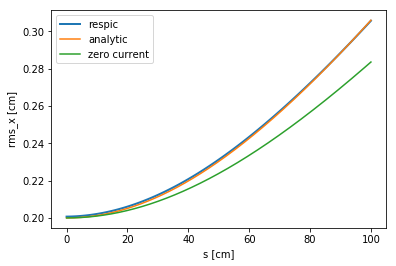

In [7]:
## Make sure opal has been run in the terminal first
x_key = 's'
y_key = 'rms_x'

plt.figure()
respic_diag.plot(x_key, y_key)
plt.plot(s_analytic, r_analytic)
plt.plot(s_analytic_z, r_analytic_z)
plt.legend(['respic', 'analytic', 'zero current'])
plt.xlabel(x_key + ' [cm]')
plt.ylabel(y_key + ' [cm]')

plt.show()